In [1]:
!pip install gymnasium
!pip install "gymnasium[atari, accept-rom-license]"
!apt-get install -y swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,178 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [2]:
import os
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable

Setting up the environment

In [3]:
import gymnasium as gym

env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

In [4]:
state = env.observation_space.shape
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
print('State shape:', state)
print('Number of actions:',action_size)
print('State size:',state_size)

State shape: (8,)
Number of actions: 4
State size: 8


Neural Network

In [5]:
class QNetwork(nn.Module):
  """Define our Neural Network"""

  def __init__(self, state_size, action_size, seed=42):
    """Initialize the Neural Network
    Params:
    state_size(int): dimension of each state
    action_size(int): dimension of each action
    seed(int): random seed
    """
    super(QNetwork, self).__init__()

    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, action_size)

  def forward(self, state):
    """Build a network that maps state to action values"""
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return self.fc4(x)

Replay Memory

In [6]:
from collections import deque, namedtuple
Transition = namedtuple('Transition', ('states', 'actions', 'next_states', 'rewards', 'dones'))

class ReplayMemory(object):
  """Using experience reply memory to train model"""

  def __init__(self, capacity):
    """Initialise the memory capacity"""
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.memory = deque([], maxlen=capacity)

  def push(self, experience):
    """Add a new experience to the memory"""
    self.memory.append(Transition(*experience))

  def sample(self, batch_size):
    """Sample a batch of experiences from the memory"""
    experiences = random.sample(self.memory, batch_size)
    states = torch.from_numpy(np.vstack([e.states for e in experiences if e is not None])).float().to(self.device)
    actions = torch.from_numpy(np.vstack([e.actions for e in experiences if e is not None])).long().to(self.device)
    rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(self.device)
    next_states = torch.from_numpy(np.vstack([e.next_states for e in experiences if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

    return states, actions, rewards, next_states, dones

  def __len__(self):
    """Return the current size of the memory"""
    return len(self.memory)

Hyperparameters

In [7]:
learning_rate = 0.0001
mini_batch = 150
gamma = 0.99
replay_buffer_size = 100000
interpolation_parameter = 0.001

Agent

In [8]:
class Agent():
  """interacts with and learns from the environment"""
  def __init__(self, state_size, action_size):
    """Initialise the agent"""
    self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    self.state_size = state_size
    self.action_size = action_size

    self.local_network = QNetwork(state_size, action_size).to(self.device)
    self.target_network = QNetwork(state_size, action_size).to(self.device)

    self.optimiser = optim.Adam(self.local_network.parameters(), lr = learning_rate, amsgrad=True)
    self.memory = ReplayMemory(replay_buffer_size)

    self.t_steps = 0

  def step(self, state, action, reward, next_state, done):
    """Save experiences to replay memory and trigger learning"""
    self.memory.push((state, action, reward, next_state, done))
    self.t_steps = (self.t_steps + 1) % 5

    loss = None

    # Randomly sample from subset if there are enough samples in the memory
    if len(self.memory) > mini_batch:
      experiences = self.memory.sample(100)
      loss = self.learn(experiences, gamma)
    return loss

  def act(self, state, epsilon=0.):
    """Handles exploitation vs. exploration tradeoff"""
    sample = random.random()
    state=torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_network.eval()

    with torch.no_grad():
      action_values = self.local_network(state)

    self.local_network.train()

    if sample > epsilon:
      return np.argmax(action_values.cpu().data.numpy())  # Exploitation
    else:
      return random.choice(np.arange(self.action_size))

  def learn(self, experiences, gamma):
    """Agent learns from replay memory"""
    states, actions, next_states, rewards, dones = experiences

    # Maximum predicted Q values for the enxt states
    qtargets_next_states = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)

    # Q targets for current states from local model
    q_targets = rewards + (gamma * qtargets_next_states * (1 - dones))

    # Get expected Q values from local model
    q_expected = self.local_network(states).gather(1, actions)

    # Compute and minimise the loss
    loss = F.mse_loss(q_expected, q_targets)
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    # update target network
    self.soft_update(self.local_network, self.target_network, interpolation_parameter)

    return loss.item()

  def soft_update(self, local_model, target_model, interpolation_param):
    """Soft update model parameters"""
    for target_param,local_param in zip(target_model.parameters(),local_model.parameters()):
      target_param.data.copy_(interpolation_parameter*local_param.data+(1.0-interpolation_parameter)*target_param.data)

In [9]:
agent = Agent(state_size, action_size)

In [ ]:
episodes_num = 1000
max_number_timestep = 1000
starting_epsilon = 0.7
ending_epsilon = 0.05
epsilon_decay_value = 0.995
epsilon = starting_epsilon
solved_score = deque(maxlen=50) # on 50 episodes

# Store losses and rewards per epsisode
losses = []
rewards_per_ep = []

for episode in range(1, episodes_num+1):
  state, _ = env.reset()
  score = 0
  episode_losses = []

  for _ in range(max_number_timestep):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)

    loss = agent.step(state, action, reward, next_state, done)

    if loss is not None:
        episode_losses.append(loss)

    state = next_state
    score += reward

    if done:
        break

  # Storing rewards and losses per episode for plotting
  rewards_per_ep.append(score)
  avg_loss = np.mean(episode_losses) if episode_losses else 0.0
  losses.append(avg_loss)

  solved_score.append(score)
  avg_score = np.mean(solved_score)
  epsilon = max(ending_epsilon, epsilon_decay_value*epsilon)

  print(f'\rEpisode {episode}\tAverage Score: {avg_score:.2f}\tLoss: {avg_loss:.4f}', end="")

  # Save the model if the environment is solved or every 50 episodes
  if episode % 50 == 0:
    print(f'\rEpisode {episode}\tAverage Score: {avg_score:.2f}\tLoss: {avg_loss:.4f}')
    torch.save(agent.local_network.state_dict(), f'checkpoint_{episode}.pth')
  if episode == episodes_num:
    print('\nTraining complete: Environment solved or maximum episodes reached.')
    torch.save(agent.local_network.state_dict(), 'checkpoint_final.pth')
    break

Episode 50	Average Score: -184.46	Loss: 23.8313
Episode 100	Average Score: -116.39	Loss: 16.8943
Episode 150	Average Score: -40.13	Loss: 9.3761
Episode 200	Average Score: 53.48	Loss: 8.0726
Episode 250	Average Score: 149.60	Loss: 5.2295
Episode 300	Average Score: 143.22	Loss: 6.1453
Episode 350	Average Score: 206.58	Loss: 8.8330
Episode 400	Average Score: 232.47	Loss: 10.0984
Episode 450	Average Score: 232.55	Loss: 10.7281
Episode 500	Average Score: 242.35	Loss: 12.7297
Episode 550	Average Score: 234.29	Loss: 11.9553
Episode 600	Average Score: 239.87	Loss: 12.2055
Episode 650	Average Score: 251.82	Loss: 9.6823
Episode 700	Average Score: 258.34	Loss: 9.2878
Episode 750	Average Score: 266.53	Loss: 7.0651
Episode 800	Average Score: 235.57	Loss: 7.4903
Episode 850	Average Score: 222.20	Loss: 6.5640
Episode 900	Average Score: 248.33	Loss: 10.1187
Episode 950	Average Score: 262.33	Loss: 8.5214
Episode 1000	Average Score: 248.03	Loss: 9.9483

Training complete: Environment solved or maximum e

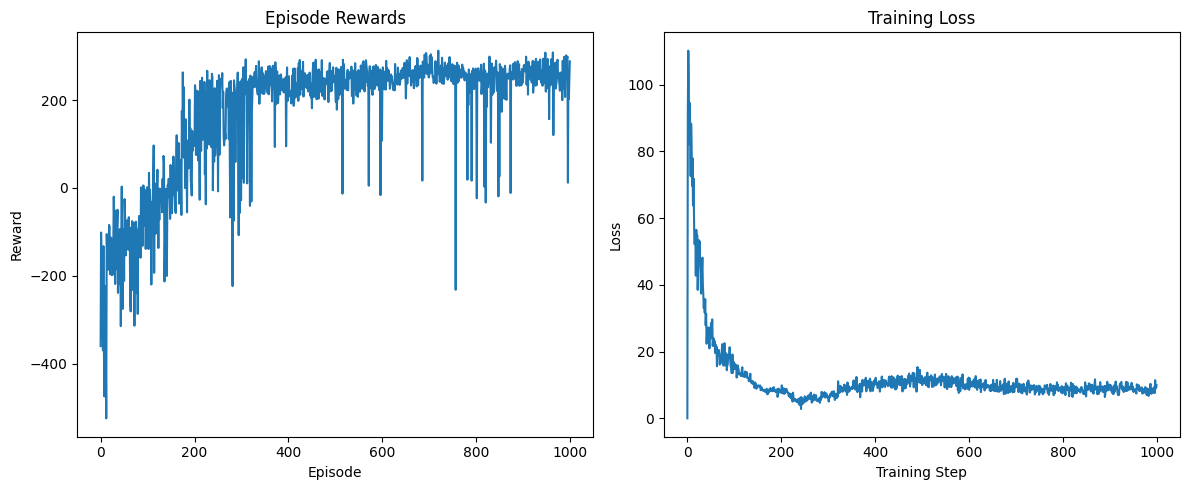

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards_per_ep)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [33]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()